# Heavy snowfall & blizzards workflow

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_2.ipynb) to launch this workflow on MyBinder. 

This is the first and simplest snow workflow.  

## Risk assessment methodology

The method involves visually representing the susceptible population exposed to intense snowfall and blizzards. This can be achieved by overlaying indicators for heavy snowfall and blizzards with population data. The objective is to comprehend the current likelihood of severe snowfall and blizzards and identify the specific regions in Europe that are most affected.

### Blizzard  

A blizzard is a severe storm condition defined by low temperature, sustained wind or frequent wind gust and considerable precipitating or blowing snow. For blizzard conditions we propose the use of following impact indicator:

**Blizzard days** = Tmean  ≤ 0 °C, Rs (snow amount) ≥ 10 cm and Wg (wind gust) ≥ 17 m/s ( Vajda et al., 2014). 

This impact indicator was defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. 


### Heavy Snow 

Heavy snowfall may cause many disruptions and impacts in various sectors; however, the impacts and consequences of this hazard depend on the affected sector, infrastructure and also preparedness of society that varies over Europe.  For example, already a few centimeters of snow can disrupt road traffic, but doesn’t normally cause any harm to energy infrastructure. Many weather services have three warning levels based on the severity of expected impacts, which are typically different for different sectors of infrastructure. There is a large variation in the national warning criteria or thresholds.

Similarly to blizzard, the impact indicators for heavy snowfall were defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. The qualitative description of the two-level thresholds are:

**1st threshold ( > 6 cm):** Some adverse impacts are expected, their severity depends on the resilience of the system, transportation is mainly affected.

**2nd threshold ( > 25 cm):**  The weather phenomena are so severe that is likely that adverse impact will occur, CI system is seriously impacted.

This code calculates the Annual probability (%) of a blizzard and heavy snowfall days during the specified period and a region of interest.


**The annual probability is calualted using following equation**

P =    ((variable > threshold) / days in year ) X 100


### Exposure data  
Exposure is assessed by overlaying the global population density map at 30 arcsec resolution using the [Global Human Settlement Population dataset](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop) dataset.

## Preparation work
### Load libraries

In this notebook we will use the following Python libraries:
- [warnings](https://docs.python.org/3/library/warnings.html) - To control the Python warning message 
- [cdsapi](https://pypi.org/project/cdsapi/) - To access the  CDS data
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pathlib](https://docs.python.org/3/library/pathlib.html) - To create Object-oriented filesystem paths
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [urllib](https://docs.python.org/3/library/urllib.html) - package for working with URLs
- [xarray](https://docs.xarray.dev/en/stable/) - To process the NetCDF data and prepare it for further calculation
- [xclim](https://xclim.readthedocs.io/en/stable/installation.html) - To correct the required data units
- [xesmf](https://xesmf.readthedocs.io/en/stable/) - Universal regridder for geospatial data
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [np](https://numpy.org) - Numerical computing tools  
- [matplotlib](https://matplotlib.org/) - To plot the maps 
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps



In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import cdsapi
import os
from pathlib import Path
import pooch
from urllib.request import urlopen

import xarray as xr
import xclim as xc
import xesmf as xe
import rioxarray as rxr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Download data

In this workflow, we will have a mix of data available to download through API and the data that must be manually downloaded from the website.

Since there is no API to download population data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to download and unzip it. 

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.


In [2]:
workflow_folder = 'snow_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [3]:
data_dir = os.path.join(workflow_folder,'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

### The Heavy snowfall & blizzards Indicator
We downloaded [ERA5 single level dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)  using the CDS API from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/#!/home). We require several variables to calculate these indicator, which are at an hourly frequency. Consequently, this analysis is limited to the data period from 1991 to 2010.

#### Download and load data into memory

We are currently retrieving data for demonstration purposes only at 00:00, 06:00, 12:00, and 18:00 UTC. However, it is feasible to obtain data for all 24 time steps. It is important to mention that we are focusing on only 4-time steps with a 6-hour interval. However, the variable "wind gust" displays the value from one hour before rather than 6 hours. Nevertheless, it remains a reliable representation.

In [4]:
c = cdsapi.Client()

# Lat Lon for Finland
area = [80, -10, 20, 45,]
#area = [70, 20, 60, 30,]
day_range=np.arange(1,32)
month_range=np.array((1,2,3,10,11,12))
varnames=['2m_temperature','10m_wind_gust_since_previous_post_processing','snow_depth','snow_density']
dataset = 'reanalysis-era5-single-levels'

# API request
params = {'format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': varnames,
        'year': list(map(str, range(1991, 2010))),
        'month': list(map("{:02d}".format, range(1,13))),
        'time': ['00:00', '06:00', '12:00', '18:00', ],
        'day': list(np.char.zfill(list(map(str, day_range)),2)),
        'grid': [0.25, 0.25],
        'area':area,}

# retrieve the location of the file
fl = c.retrieve(dataset, params)

# load into memory
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read())

2024-01-24 14:15:12,421 INFO Welcome to the CDS
2024-01-24 14:15:12,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-01-24 14:15:12,605 INFO Request is queued
2024-01-24 15:20:02,657 INFO Request is running
2024-01-24 16:50:27,342 INFO Request is completed


#### Convert unit of input variables 
Temperature (Kelvin) --> Temperature -273.15 (deg C)

Snow depth  (m of water equivalent)  -->Snow depth (cm) 

   Snow depth (m) = (RW X SD) / RSN
   
     where:
      SD= snow depth in m of water equivalent
      RW, density of water, = 1000 kg/m3
      RSN = density of snow in kg/m3
 Snow depth (cm) --> Snow depth (m) X 100

In [ ]:
ds['t2m']  = xc.units.convert_units_to(ds.t2m, "degC")

ds['snow_depth'] = 1000 * ds.sd / ds.rsn
ds = ds.drop(['sd','rsn'])
ds['snow_depth'] = ds.snow_depth.assign_attrs(units="m", description="snow depth")
ds['snow_depth'] = xc.units.convert_units_to(ds.snow_depth, "cm")

####  Resampling to daily data

According to the ERA5 convention, accumulated variables aggregate data from 00 UTC to the next 24 hours (i.e., the accumulation at 00 UTC represents the sum of values during the previous day). Therefore, before archiving accumulated variables, we shifted the time axis by one timestep to ensure that the accumulations at 00 UTC correspond to the actual day.


In [66]:
ds = ds.shift(time=1)

tas_day        = ds.t2m.resample(time='24H').mean('time')
wspd_day       = ds.fg10.resample(time='24H').max('time')
snow_depth_day = ds.snow_depth.resample(time='24H').mean('time')

#### Define thresholds 

**Thresholds for Blizzard days**

Temperature threshold --> lim_tas    = 0.

Snow threshold          -->lim_snow10 = 10.

Wind gust threshold   -->lim_gust   = 17.


**Heavy Snow thresholds** 

Snow exceding 6cm threshold  -->lim_snow6  = 6.

Snow exceding 25cm threshold -->lim_snow25 = 25.



In [67]:
#| Define thresholds 
lim_tas    = 0.
lim_snow10 = 10.
lim_gust   = 17.

lim_snow6  = 6.
lim_snow25 = 25.

#### Calculate the probability of occurence

In [68]:
#| The probability of occurrence of at least one blizzard day

BdayCount_anaProb = ((tas_day
                      < lim_tas) * (snow_depth_day > lim_snow10) * (wspd_day > lim_gust)).groupby('time.year').sum('time')
#del tas_day, wspd_day
total_days_per_year = snow_depth_day.groupby('time.year').count(dim='time')

BdayCount_anaProb = (BdayCount_anaProb / total_days_per_year) * 100

BdayCount_anaProb = BdayCount_anaProb.where(BdayCount_anaProb != 0.)
BdayCount_anaProb = BdayCount_anaProb.assign_attrs(units="%", long_name="Annual probability of blizzard days")
BdayCount_anaProb = BdayCount_anaProb.to_dataset(name='blizzard_days')

BdayCount_anaProb_mean = BdayCount_anaProb.mean('year')

BdayCount_anaProb_mean.to_netcdf(path=os.path.join(data_dir, "BdayCount_AnaProb_mean.nc"))
del BdayCount_anaProb


#| Probability of occurrence of at least one day with snowfall > 6cm

snow6Count_anaProb = (snow_depth_day > lim_snow6).groupby('time.year').sum('time')

snow6Prob_annual = (snow6Count_anaProb / total_days_per_year) * 100

snow6Prob_annual = snow6Prob_annual.where(snow6Prob_annual != 0.)
snow6Prob_annual = snow6Prob_annual.assign_attrs(units="%", long_name="Annual probability of snow days")
snow6Prob_annual = snow6Prob_annual.to_dataset(name='snow_days')

snow6Prob_annual_mean = snow6Prob_annual.mean('year')
snow6Prob_annual_mean.to_netcdf(path=os.path.join(data_dir, "snow6Prob_annual_mean.nc"))
del snow6Prob_annual


#| Probability of occurrence of at least one day with snowfall > 25cm
snow25Count_anaProb = (snow_depth_day > lim_snow25).groupby('time.year').sum('time')

snow25Prob_annual = (snow25Count_anaProb / total_days_per_year) * 100

snow25Prob_annual = snow25Prob_annual.where(snow25Prob_annual != 0.)
snow25Prob_annual = snow25Prob_annual.assign_attrs(units="%", long_name="Annual probability of snow days")
snow25Prob_annual = snow25Prob_annual.to_dataset(name='snow_days')

snow25Prob_annual_mean = snow25Prob_annual.mean('year')
snow25Prob_annual_mean.to_netcdf(path=os.path.join(data_dir, "snow25Prob_annual_mean.nc"))
del snow25Prob_annual

## Explore the results
Having acquired the data and computed the required indicator, we proceed to create visual plots for data exploration. 

### Annual probability plot of indicator


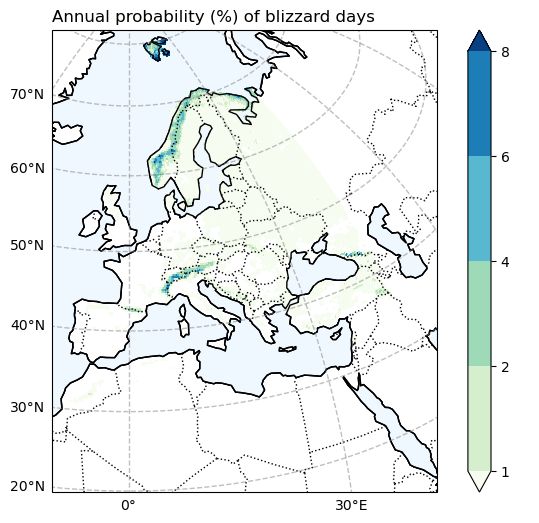

In [69]:
np.warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(8, 6))
p_levels = [ 1,2,4, 6,8]

p = BdayCount_anaProb_mean.blizzard_days.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels, 
    cbar_kwargs={"label": "  "},
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()
plt.title('Annual probability (%) of blizzard days', loc = "left")

# Add coastlines and features

p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
plt.show()

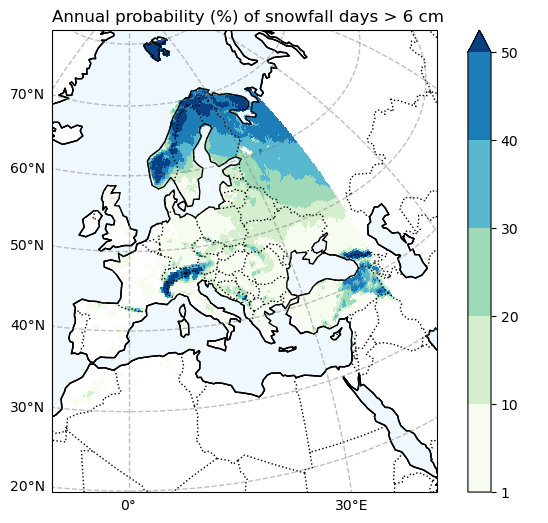

In [58]:
# Filter the data to exclude values less than 1
filtered_data = snow6Prob_annual_mean.snow_days.where(snow6Prob_annual_mean.snow_days >= 1)

fig = plt.figure(figsize=(8, 6))
p_levels = [1, 10, 20, 30, 40, 50]

p = filtered_data.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels,
    cmap="GnBu",
    cbar_kwargs={"label": " "},
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
plt.title('Annual probability (%) of snowfall days > 6 cm  ', loc="left")

# Add coastlines and features
p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

plt.show()

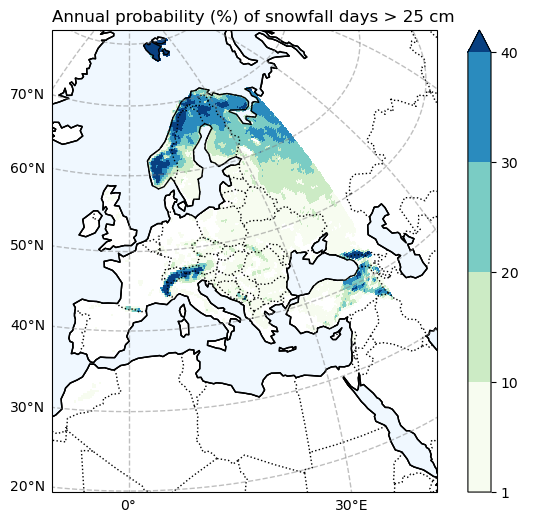

In [59]:
# Filter the data to exclude values less than 1
filtered_data = snow25Prob_annual_mean.snow_days.where(snow25Prob_annual_mean.snow_days >= 1)

fig = plt.figure(figsize=(8, 6))
p_levels = [1, 10, 20, 30, 40]

p = filtered_data.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels,
    cmap="GnBu",
    cbar_kwargs={"label": " "},
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
plt.title('Annual probability (%) of snowfall days > 25 cm  ', loc="left")

# Add coastlines and features
p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

plt.show()

### Population data
First, we need population information, which will be obtained from the JRC data portal. After downloading and extracting the data, Pooch will list the contents within the data directory. In this illustration, we are using population data sourced from the JRC data portal, specifically the Global Human Settlement Layer (GHSL), with 30 arcsec resolution global datasets

In [60]:
url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2015_GLOBE_R2023A_4326_30ss/V1-0/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.zip'
pooch.retrieve(
    url=url,
    known_hash=None,
    path=data_dir,
    processor=pooch.Unzip(extract_dir=''))


['/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/output_figure.png',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/.DS_Store',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/Snow_day_bins_map.png',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/GHSL_Data_Package_2023.pdf',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/GHS_POP_GLOBE_R2023A_input_metadata.xlsx',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/Annual_probability_blizzard_map.png',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/3f1ff4bbec190dc119ca69ea4a78081a-GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.zip',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/BiaVar_map.png',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/Europe_population_

The zip file contains data, as well as metadata and the documentation in the pdf file.

Population data is in file with filename: **GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif**

We can use rioxarray to load this file and explore the projections of the dataset.

In [61]:
filename_population = f'{data_dir}/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif'

population = rxr.open_rasterio(filename_population)
population

population = population.rename({'x': 'longitude','y': 'latitude'})
population.rio.crs

CRS.from_epsg(4326)

Note that now, we have a directory **snow_workflow/data** where all the zip files and unzipped files are stored.

We can list all the files in the **data_dir** using the **os** library.  

In [62]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

output_figure.png
.DS_Store
Snow_day_bins_map.png
GHSL_Data_Package_2023.pdf
GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif
OLD
GHS_POP_GLOBE_R2023A_input_metadata.xlsx
Annual_probability_blizzard_map.png
3f1ff4bbec190dc119ca69ea4a78081a-GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.zip
BiaVar_map.png
Europe_population_25deg.nc
snow6Prob_annual_mean.nc
snow25Prob_annual_mean.nc
Annual_probability_25mm_map.png
GHS_POP_E2015_GLOBE_R2023A_4326_3ss_V1_0.tif.ovr
Annual_probability_6mm_map.png
population_density_map.png
GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif.ovr
BdayCount_AnaProb_mean.nc
GHS_POP_E2015_GLOBE_R2023A_4326_3ss_V1_0.tif
population_density_bins_map.png
3715b62c6d9fd406faa76fe9012ff9f5-GHS_POP_E2015_GLOBE_R2023A_4326_3ss_V1_0.zip


## Process the data

In this workflow, we want to overlay the population data on snowfall and blizzard indicators to better understand where these indicators affect densely populated areas. 

Take a closer look at the dimensions and coordinates of our two data objects. 
- Notice that the population data has **x** and **y** as spatial dimensions, while ERA5 has **latitude** and **longitude**. 
- Both datasets are in the same projection: **WSG84/epsg 4326**. 
- However, the resolutions of the datasets are different. 

To be able to plot these two datasets together, we must have them at the same resolution and zoomed in to the same area

### Regrid and explore the data

We utilize the xESMF library, a Universal Regridder for Geospatial Data, to regrid the population data to match the ERA5 resolution. Prior to regridding, the population data is cropped specifically for the European region.

**regrid the population data** 

In [63]:
Europe_population = population.sel(latitude=slice(80.0,20.0), longitude=slice(-10.0,45.0))

snow6Prob_annual_mean.rio.crs
snow6Prob_annual_mean.rio.write_crs(4326, inplace=True)

regridder = xe.Regridder(Europe_population, snow6Prob_annual_mean, 'bilinear', periodic=True)
 
Europe_population_025deg = regridder(Europe_population)

Europe_population_025deg.to_netcdf(path=os.path.join(data_dir, "Europe_population_25deg.nc"))

**Explore the regridded population data**

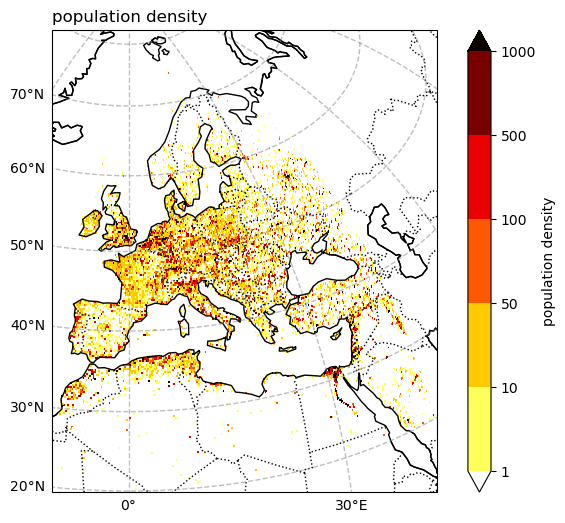

In [64]:
del Europe_population_025deg['band']
del Europe_population_025deg['spatial_ref']

fig = plt.figure(figsize=(8, 6))
p_levels = [ 1,10,50,100,500,1000]

p = Europe_population_025deg.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels,
    cbar_kwargs={"label": "population density"},
    cmap="hot_r",
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()
plt.title(' ', loc = "left")
plt.title('population density ', loc = "left")

# Add coastlines and features

p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
plt.savefig('/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/population_density_map.png', dpi=300, bbox_inches='tight')


### Select the area of interest
We are currently selecting the Alpine region because pollution density is higher in this area, and there is also a greater probability of heavy snow and blizzards, using the specified latitude and longitude extents, which can be modified as needed.


In [70]:
xmin=4  # Min Longitude 
xmax=15 # Max Longitude 

ymin=42 # Min Latitude 
ymax=50 # Max Latitude 

SelArea_population = Europe_population_025deg.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))

SelArea_6cm_ind = snow6Prob_annual_mean.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))
SelArea_25cm_ind = snow25Prob_annual_mean.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))
SelArea_blizard_ind = BdayCount_anaProb_mean.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))


### To explore the exposure and vulnerability of the population, plot them together

We are considering two approaches: 1) overlaying population density on snow indices and 2) exclusively plotting snow indices in regions where population density surpasses 1/km.

**overlay Plot**

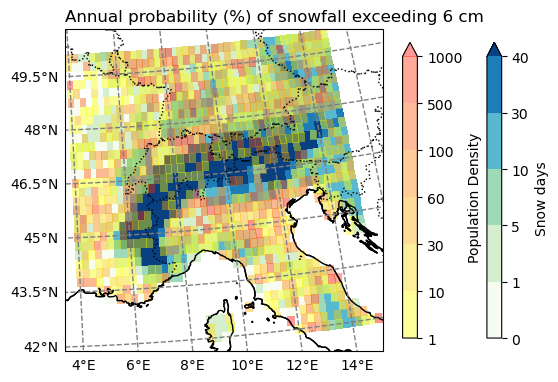

In [71]:
# Plot snow probability
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, 35)})

snow_levels = [0, 1, 5, 10, 30, 40]
pop_levels = [1, 10, 30, 60, 100, 500, 1000]

SelArea_6cm_ind.snow_days.plot(
    ax=ax1,
    levels=snow_levels,
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Snow days", "shrink": 0.8},
    alpha=1.0
)

ax1.coastlines()
ax1.set_title('Annual probability (%) of snowfall exceeding 6 cm', loc="left")

# Add coastlines and features
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add latitude and longitude labels
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Overlay population density where it's larger than 1
mask = SelArea_population >= 1
SelArea_population.where(mask).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="autumn_r",
    levels=pop_levels,
    cbar_kwargs={"label": "Population Density", "shrink": 0.8},
    alpha=0.4  # Adjust transparency for better visibility
)

plt.show()

**Mask Plot**

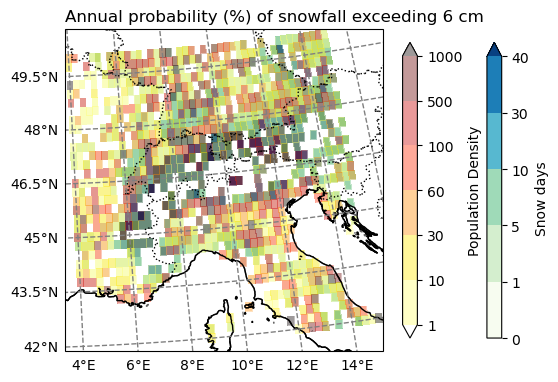

In [72]:
# Create a mask for snow data where pollution density is below 1
snow_data_masked = SelArea_6cm_ind.snow_days.where(SelArea_population >= 1)

# Plot snow probability
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, 35)})

snow_levels = [0, 1, 5, 10, 30, 40]
pop_levels = [1, 10, 30, 60, 100, 500, 1000]

snow_data_masked.plot(
    ax=ax1,
    levels=snow_levels,
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Snow days", "shrink": 0.8},
    alpha=1.0
)

ax1.coastlines()
ax1.set_title('Annual probability (%) of snowfall exceeding 6 cm', loc="left")

# Add coastlines and features
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add latitude and longitude labels
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Overlay population density on the same subplot
mesh = SelArea_population.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="hot_r",
    levels=pop_levels,
    cbar_kwargs={"label": "Population Density", "shrink": 0.8},
    alpha=0.4
)

plt.show()

The second approach is more beneficial for conducting climate risk assessments. Therefore, we will explore all snow indices using this second approach.

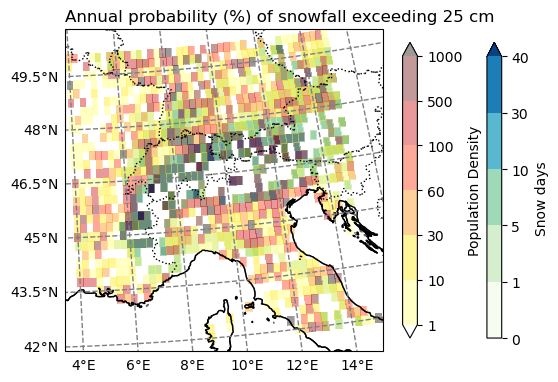

In [73]:
# Create a mask for snow data where pollution density is below 1
snow_data_masked = SelArea_25cm_ind.snow_days.where(SelArea_population >= 1)

# Plot snow probability
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, 35)})

snow_levels = [0, 1, 5, 10, 30, 40]
pop_levels = [1, 10, 30, 60, 100, 500, 1000]

snow_data_masked.plot(
    ax=ax1,
    levels=snow_levels,
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Snow days", "shrink": 0.8},
    alpha=1.0
)

ax1.coastlines()
ax1.set_title('Annual probability (%) of snowfall exceeding 25 cm', loc="left")

# Add coastlines and features
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add latitude and longitude labels
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Overlay population density on the same subplot
mesh = SelArea_population.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="hot_r",
    levels=pop_levels,
    cbar_kwargs={"label": "Population Density", "shrink": 0.8},
    alpha=0.4
)


plt.show()

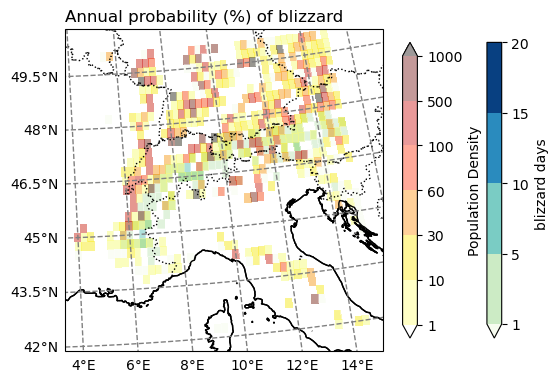

In [74]:
# Create a mask for snow data where pollution density is below 1
snow_data_masked = SelArea_blizard_ind.blizzard_days.where(SelArea_population > 0)

population_masked = SelArea_population.where(SelArea_blizard_ind.blizzard_days > 0)

# Plot snow probability
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, 35)})

snow_levels = [ 1,5,10,15,20]
pop_levels = [1, 10, 30, 60, 100, 500, 1000]

snow_data_masked.plot(
    ax=ax1,
    levels=snow_levels,
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "blizzard days", "shrink": 0.8},
    alpha=1.0
)

ax1.coastlines()
ax1.set_title('Annual probability (%) of blizzard', loc="left")

# Add coastlines and features
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add latitude and longitude labels
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Overlay population density on the same subplot
mesh = population_masked.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="hot_r",
    levels=pop_levels,
    cbar_kwargs={"label": "Population Density", "shrink": 0.8},
    alpha=0.4
)

plt.show()

## Conclusions
In this workflow, we've illustrated the process of exploring, processing, and visualizing data necessary for analyzing the influence of heavy snowfall and blizzard day indices on population density. These indices are presented as annual probabilities of occurrence, reflecting the likelihood of a particular event happening over several years. In the present climate, communities in the northern Alpine region face heightened vulnerability to heavy snowfall and blizzards.

## Contributors
Suraj Polade, FMI 

Andrea Vajda, FMI 